# Siamese Network for One Shot Learning

### 1. Problem statement and problem approach:
Suppose you run a company of say 20 employees where you want to install a face detection enabled door lock. You ask each of your employees to provide you a photograph that you want to feed in your database. The problem of this sort in machine learning is termed as one shot learning (where you have to recognise against only one entry from the database).
In order to do so, we train our model on a large corpus of images (not just the employees) with the aim to make our model learn distinguish between same and different images (not just the employees) provided to it. The architecture that helps us do is the Siamese network.

### 2. Description of data:
We have collected a corpus of images of 200 celebrities. For each celebrity image (the anchor) we feed to the network another image of the same celebrity (the positive) and one other image of a different celebrity (the negative). So all in all we have 200 triplets of anchor-positive-negative (i.e. 600 images).

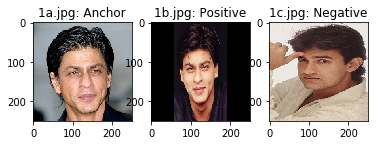

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
path1 = '/home/amula/Downloads/MLYoutube/Project1Final/Data'
im1 = Image.open(path1 + '/' + '1a.jpg') 
im1 = im1.resize((250,250))
im2 = Image.open(path1 + '/' + '1b.jpg') 
im2 = im2.resize((250,250))
im3 = Image.open(path1 + '/' + '1c.jpg') 
im3 = im3.resize((250,250))
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("1a.jpg: Anchor")
ax1.imshow(im1)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("1b.jpg: Positive")
ax2.imshow(im2)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("1c.jpg: Negative")
ax3.imshow(im3)

### 3. Preprocessing the data:

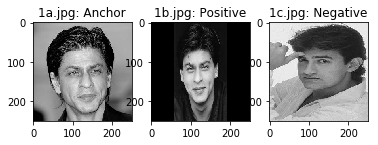

In [4]:
import os
import numpy as np
from numpy import *
path1 = '/home/amula/Downloads/MLYoutube/Project1Final/Data'
path2 = '/home/amula/Downloads/MLYoutube/Project1Final/DataProcessed'
listing = sorted(os.listdir(path1)) #this makes an array of image names as strs
num_samples = size(listing)

for str in listing:
    im = Image.open(path1 + '/' + str)  #these all operations come from
    img = im.resize((250,250))
    gray = img.convert('L')
    gray.save(path2 + '/' + str)

im1 = Image.open(path2 + '/' + '1a.jpg') 
im1 = im1.resize((250,250))
im2 = Image.open(path2 + '/' + '1b.jpg') 
im2 = im2.resize((250,250))
im3 = Image.open(path2 + '/' + '1c.jpg') 
im3 = im3.resize((250,250))
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("1a.jpg: Anchor")
ax1.imshow(im1)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title("1b.jpg: Positive")
ax2.imshow(im2)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title("1c.jpg: Negative")
ax3.imshow(im3)

### 4. The code part by part:

##### Importing images as arrays and arranging them as a matrix:

In [5]:
imlist = sorted(os.listdir(path2))
immatrix = array([array(array(Image.open(path2 + '/' + im)).flatten()) for im in imlist],'f')
print(immatrix.shape)

(600, 62500)


##### Arraging anchor-positive and anchor-negative together:

In [6]:
immatrixnew = np.zeros([400,2*250*250])
for i in range(1,201):
    immatrixnew[2*i-2,:250*250] = immatrix[3*i-3,:]
    immatrixnew[2*i-2,250*250:] = immatrix[3*i-2,:]
    immatrixnew[2*i-1,:250*250] = immatrix[3*i-3,:]
    immatrixnew[2*i-1,250*250:] = immatrix[3*i-1,:]

##### Making corresponding labels, 1 for Anchor-Positive and 0 for Anchor-Negative:

In [7]:
labels = np.zeros([400,1])
for i in range(0,400): 
    if i%2 == 0:
        labels[i] = 1
    elif i%2 == 1:
        labels[i] = 0

##### Shuffling and dividing the data in test and train sets:

In [8]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

X,y = shuffle(immatrixnew, labels, random_state=2) #random state insures same shuffling each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


##### Feature Scaling:

In [9]:
X_train /= 255
X_test /= 255

##### Separating images to be fed into the Keras model:

In [10]:
X_train_a = X_train[:,:62500]
X_train_b = X_train[:,62500:]
X_test_a = X_test[:,:62500]
X_test_b = X_test[:,62500:]

##### The Keras Model:

In [11]:
import keras
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.models import Model
from keras import optimizers

Using TensorFlow backend.


In [12]:
#Vision Model
ImageData = Input(shape=(62500,))
ImageData_reshaped = keras.layers.Reshape(target_shape=(250,250,1))(ImageData)
x = Conv2D(filters=3,kernel_size=5,strides=(1,1),padding='same',activation='tanh')(ImageData_reshaped) #187500
x = MaxPooling2D(pool_size=(2,2),strides=None,padding='valid')(x) #46875
x = Conv2D(filters=2,kernel_size=5,strides=(1,1),padding='same',activation='tanh')(x) #31250
x = MaxPooling2D(pool_size=(5,5),strides=None,padding='valid')(x) #1250
x = Flatten()(x)
out = Dense(312,activation='tanh',use_bias=True)(x)
vision_model = Model(ImageData,out)

In [13]:
#Classification Model
image_a = Input(shape=(62500,))
image_b = Input(shape=(62500,))
out_image_a = vision_model(image_a)
out_image_b = vision_model(image_b)
subtracted = keras.layers.subtract([out_image_a,out_image_b])
out2 = Dense(1, activation='sigmoid')(subtracted)
classification_model = Model([image_a, image_b], out2)

In [14]:
#rmsprop = optimizers.RMSprop(lr=0.0001)
#classification_model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
#classification_model.fit(x=[X_train_a, X_train_b],y=y_train, epochs=100, batch_size=32, verbose=2, validation_data=([X_test_a, X_test_b],y_test))

##### The logs of the run made using FloydHub:

In [15]:
f = open('floydlogs.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

2018-05-20 05:48:03,817 INFO - Preparing to run TaskInstance <TaskInstance: amula/projects/project1final/2 (id: JSKjScupSGvs3rGY6vRoza)
2018-05-20 05:48:03,830 INFO - Starting attempt 1 at 2018-05-20 12:48:03.822022
2018-05-20 05:48:03,843 INFO - Downloading and setting up data sources
2018-05-20 05:48:03,850 INFO - Downloading and mounting dataset. ETA: 2 seconds
2018-05-20 05:48:04,614 INFO - Pulling Docker image: floydhub/tensorflow:1.3.1-py3_aws.13
2018-05-20 05:48:05,873 INFO - Starting container...
2018-05-20 05:48:06,128 INFO - 
################################################################################

2018-05-20 05:48:06,128 INFO - Run Output:
2018-05-20 05:48:06,188 INFO - Starting services.
2018-05-20 05:48:10,810 INFO - /usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that t

### 5. Summary:
Clearly we have an overfitting model. Possible solution could be to gather more data or to import the weights from a pre-trained network for our layers (and also mould the network architecture architecture accordingly).